# Neural Modelling Exercise 4

Submitted by **Mohammed Abbas Ansari** and **Kai Rothe**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

In [2]:
data = pd.read_csv("gen_data.csv")

##### 1. Recreating Figure 2E from "Go and no-go learning in reward andpunishment: Interactions between affect and effect” 

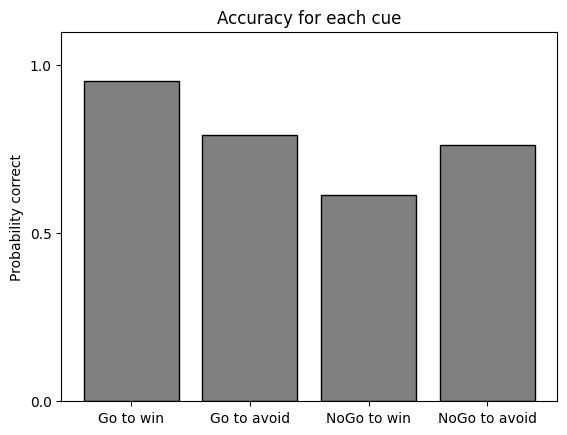

In [61]:
cue_mapping = {1: 'Go to win', 2: 'Go to avoid', 3: 'NoGo to win', 4: 'NoGo to avoid'}  # Go+ = Go to win, Go- = go to avoid losing, NoGo+ = don't go to win, NoGo- = don't go to avoid losing

cue_correct_response_map = {1: 1, 2: 1, 3: 0, 4: 0} # 1 = go, 0 = no go 

# exercise 1: plot the accuracy for each cue
accuracies = {}
for cue in cue_mapping:
    n = data[data["cue"] == cue].shape[0]
    accuracies[cue_mapping[cue]] = np.logical_and(data["cue"] == cue, data["pressed"] == cue_correct_response_map[cue]).sum() / n;
    
# plot a historam of accuracies with y-axis labeled "probability correct" and x-axis with the cue names from cue_mapping
plt.bar(accuracies.keys(), accuracies.values(), align="center", color="gray", edgecolor="black");
plt.ylabel("Probability correct")
plt.title("Accuracy for each cue")
# determing the y-axis limits and each possible value of y-axis
plt.ylim(0, 1.1)
plt.yticks([0, 0.5, 1])
plt.show()

##### 2. & 3. Programming Different Q-learner models

In [4]:
class BaseModel:
    def __init__(self):
        self.data = None
        self.params = {"lr": 0.1, "beta": 1}
    
    def set_params(self, param_list):
        for i, key in enumerate(self.params.keys()): self.params[key] = param_list[i]
    
    def set_data(self, data):
        self.data = [(cue, action, outcome) for cue, action, outcome in zip(data["cue"], data["pressed"], data["outcome"])]
        
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x))
    
    def compute_neg_log_likelihood(self, param_list):
        assert self.data is not None, "Data is not set"
        
        self.set_params(param_list)             # set the parameters for model
        self.q = np.zeros((4,2))                # 4 cues, 2 actions
        likelihoods = np.zeros(len(self.data))
        
        for i, (cue, action, outcome) in enumerate(self.data):
            likelihoods[i] = self.compute_likelihood(cue, action) # compute the likelihood of choosing that action given the cue
            self.update_q(cue, action, outcome)                   # update q-value of that action based on the outcome

        return -np.sum(np.log(likelihoods))
    
    def compute_likelihood(self, cue, action):
        return self.softmax(self.q[cue-1])[action]
    
    def update_q(self, cue, action, outcome):
        self.q[cue-1, action] += self.params["lr"] * (outcome*self.params["beta"] - self.q[cue-1, action])
        
    def __str__(self) -> str:
        return ", ".join([f"{key}: {value}" for key, value in self.params.items()])

In [141]:
class Model1(BaseModel):
    def __init__(self):
        super().__init__()        

class Model2(BaseModel):
    def __init__(self):
        super().__init__()
        del self.params["beta"]
        self.params.update({"rew": 1, "pun": 1}) # different sensitivty for reward and punishment
        
    def update_q(self, cue, action, outcome):
        Rt = self.params["rew"] if outcome == 1 else self.params["pun"] if outcome == -1 else 0
        self.q[cue-1, action] += self.params["lr"] * (Rt - self.q[cue-1, action])

class Model3(BaseModel):
    def __init__(self):
        super().__init__()
        del self.params["lr"]
        self.params.update({"lr_rew": 0.1, "lr_pun": 0.1, "lr_omiss": 0.1}) # different learning rates for reward, punishment, and omissions
        
    def update_q(self, cue, action, outcome):
        lr = self.params["lr_rew"] if outcome == 1 else self.params["lr_pun"] if outcome == -1 else self.params["lr_omiss"]
        self.q[cue-1, action] += lr * (outcome*self.params["beta"] - self.q[cue-1, action])
        
class Model4(BaseModel):
    def __init__(self):
        super().__init__()
        self.params.update({"bias_app": 0.5, "bias_wth": 0.5}) # bias for approach and withdrawal to be added to q-values
        self.bias = np.array([self.params["bias_wth"], self.params["bias_app"]])
        
    def set_params(self, param_list):
        super().set_params(param_list)
        self.bias = np.array([self.params["bias_wth"], self.params["bias_app"]])
        
    def compute_likelihood(self, cue, action):
        return self.softmax(self.q[cue-1] + self.bias)[action]

class Model5(Model4):
    def __init__(self):
        super().__init__()
        del self.params["beta"] 
        self.params.update({"rew": 1, "pun": 1}) # different sensitivty for reward and punishment
    
    def update_q(self, cue, action, outcome):
        Rt = self.params["rew"] if outcome == 1 else self.params["pun"] if outcome == -1 else 0
        self.q[cue-1, action] += self.params["lr"] * (Rt - self.q[cue-1, action])

class Model6(Model4):
    def __init__(self):
        super().__init__()
        del self.params["beta"]
        self.params.update({"rew_app": 1, "pun_app": 1, "rew_wth": 1, "pun_wth": 1}) # different sensitivty for reward and punishment depending on action
    
    def update_q(self, cue, action, outcome):
        Rt = 0
        if action == 1:
            Rt = self.params["rew_app"] if outcome == 1 else self.params["pun_app"] if outcome == -1 else 0
        else:
            Rt = self.params["rew_wth"] if outcome == 1 else self.params["pun_wth"] if outcome == -1 else 0
            
        self.q[cue-1, action] += self.params["lr"] * (Rt - self.q[cue-1, action])

class Model7(Model5):
    def __init__(self):
        super().__init__()
        del self.params["lr"]
        self.params.update({"lr_app": 0.1, "lr_wth": 0.1}) # different learning rates for approach and withholding conditions

    def update_q(self, cue, action, outcome):
        lr = self.params["lr_app"] if cue in [1,2] else self.params["lr_wth"] # choose appropriate learning rate based on cue/condition
        Rt = self.params["rew"] if outcome == 1 else self.params["pun"] if outcome == -1 else 0
        self.q[cue-1, action] += lr * (Rt - self.q[cue-1, action])
        
class Model8(Model7):
    def __init__(self):
        super().__init__()
        self.params.update({"p": 0.5})
    
    def compute_likelihood(self, cue, action):
        max_q = np.max(self.q[cue-1])
        W = self.q[cue-1] + self.bias
        if max_q > 0: 
            W[1] += self.params["p"] # add p to approach action if maximal Q value is positive
        elif max_q < 0:
            W[0] += self.params["p"] # add p to withhold action if maximal Q value is negative
        return self.softmax(W)[action]

In [142]:
model1 = Model1()
model2 = Model2()
model3 = Model3()
model4 = Model4()
model5 = Model5()
model6 = Model6()
model7 = Model7()
model8 = Model8()
all_models = [model1, model2, model3, model4, model5, model6, model7, model8]

for i, model in enumerate(all_models):
    print(f"Model {i+1}:\n ↳{model}\n")

Model 1:
 ↳lr: 0.1, beta: 1

Model 2:
 ↳lr: 0.1, rew: 1, pun: 1

Model 3:
 ↳beta: 1, lr_rew: 0.1, lr_pun: 0.1, lr_omiss: 0.1

Model 4:
 ↳lr: 0.1, beta: 1, bias_app: 0.5, bias_wth: 0.5

Model 5:
 ↳lr: 0.1, bias_app: 0.5, bias_wth: 0.5, rew: 1, pun: 1

Model 6:
 ↳lr: 0.1, bias_app: 0.5, bias_wth: 0.5, rew_app: 1, pun_app: 1, rew_wth: 1, pun_wth: 1

Model 7:
 ↳bias_app: 0.5, bias_wth: 0.5, rew: 1, pun: 1, lr_app: 0.1, lr_wth: 0.1

Model 8:
 ↳bias_app: 0.5, bias_wth: 0.5, rew: 1, pun: 1, lr_app: 0.1, lr_wth: 0.1, p: 0.5



##### 4. Model Optimization

In [143]:
initial_params = {'lr': 0.1,
                  'beta': 1,
                  'rew': 1,
                  'pun': -1,
                  'lr_rew': 0.1,
                  'lr_pun': 0.1,
                  'lr_omiss': 0.1,
                  'bias_app': 0.1,
                  'bias_wth': 0.1,
                  'rew_app': 1,
                  'pun_app': -1,
                  'rew_wth': 1,
                  'pun_wth': -1,
                  'lr_app': 0.1,
                  'lr_wth': 0.1,
                  'p': 0.1}

param_bounds = {'lr': (1e-5, 1-1e-5),
                'beta': (1e-5, 100),
                'rew': (-100,100),
                'pun': (-100,100),
                'lr_rew': (1e-5, 1-1e-5),
                'lr_pun': (1e-5, 1-1e-5),
                'lr_omiss': (1e-5,1-1e-5),
                'bias_app': (-10,10),
                'bias_wth': (-10,10),
                'rew_app': (-100,100),
                'pun_app': (-100,100),
                'rew_wth': (-100,100),
                'pun_wth': (-100,100),
                'lr_app': (1e-5,1-1e-5),
                'lr_wth': (1e-5,1-1e-5),
                'p': (-10,10)}

In [144]:
unique_subjects = data["ID"].unique()
subjects_data = [data[data["ID"] == subject].reset_index(drop=True) for subject in unique_subjects]
method = 'Nelder-Mead'
neg_log_likelihoods = np.zeros((len(all_models), len(unique_subjects)))
best_params_dict = {}

for i, model in enumerate(all_models):
    best_params_dict[i+1] = {}
    initial_params_list = [initial_params[key] for key in model.params.keys()]
    param_bounds_list = [(param_bounds[key]) for key in model.params.keys()]
    print(f"Fitting Model {i+1}")
    
    for subject, subject_data in enumerate(tqdm(subjects_data)):
        model.set_data(subject_data)
        best_params = minimize(model.compute_neg_log_likelihood, initial_params_list, bounds=param_bounds_list, method=method)
        neg_log_likelihoods[i, subject-1] = best_params.fun
        best_params_dict[i+1][subject] = best_params.x

Fitting Model 1


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Fitting Model 2


100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Fitting Model 3


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


Fitting Model 4


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Fitting Model 5


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Fitting Model 6


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


Fitting Model 7


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Fitting Model 8


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


##### 5. Log-Likelihoods and BIC Comparisons

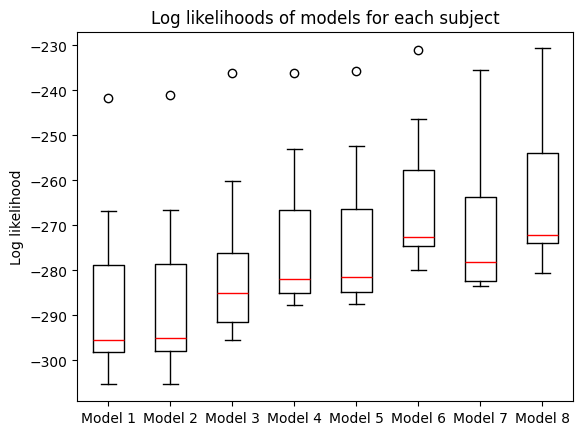

In [145]:
# make a boxplot of all log likelihoods
plt.boxplot(-neg_log_likelihoods.T, medianprops=dict(color="red"))
plt.xticks(range(1, len(all_models)+1), [f"Model {i+1}" for i in range(len(all_models))])
plt.ylabel("Log likelihood")
plt.title("Log likelihoods of models for each subject")
plt.show();

Text(0.5, 1.0, 'Summed-up Log likelihoods of models across Subjects')

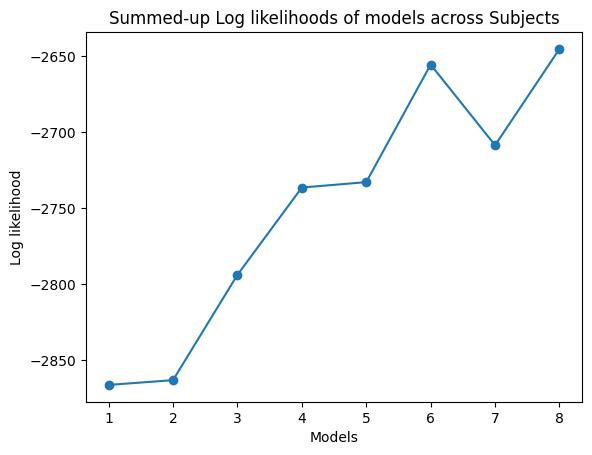

In [146]:
y = - np.sum(neg_log_likelihoods, axis=-1)
x = np.arange(1, 9)
plt.plot(x, y, 'o-')
plt.xlabel("Models")
plt.ylabel("Log likelihood")
plt.title("Summed-up Log likelihoods of models across Subjects")

In [147]:
# Models and their descriptions
model_descriptions = [
    r"Model 1: ε, β⁠",
    r"Model 2: ε, $ρ_{rew}, ρ_{pun}$",
    r"Model 3: $ε_{rew}, ε_{pun}$, β",
    r"Model 4: ε, β, $bias_{app}, bias_{wth}$",
    r"Model 5: ε, $ρ_{rew}, ρ_{pun}$, $bias_{app}, bias_{wth}$",
    r"Model 6: ε, $ρ_{rew}^{app}, ρ_{pun}^{app}, ρ_{rew}^{wth}, ρ_{pun}^{wth}$, $bias_{app}, bias_{wth}$",
    r"Model 7: $ε_{app}, ε_{wth}$, $ρ_{rew}, ρ_{pun}$, $bias_{app}, bias_{wth}$",
    r"Model 8: $ε_{app}, ε_{wth}, ρ_{rew}, ρ_{pun}, bias_{app}, bias_{wth}, p$",
]


In [148]:
NLL_summed = np.sum(neg_log_likelihoods, axis=-1)
BIC_scores = {}
for model_num, model in enumerate(all_models):
    num_params = len(model.params)
    BIC_scores[model_num+1] = 2 * NLL_summed[model_num] + num_params * np.log(data.shape[0]) # BIC formula from Wikipedia

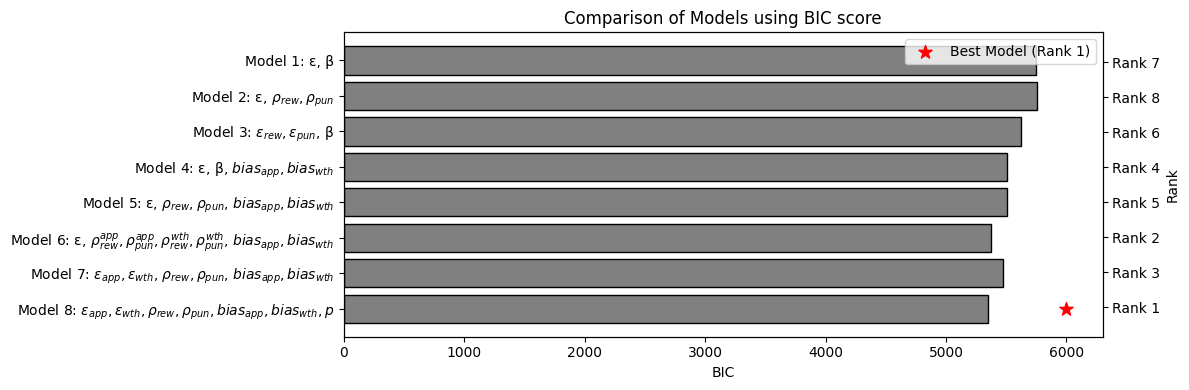

In [149]:
scores = list(BIC_scores.values())
min_score = min(scores)
# delta_BIC = [score - min_score for score in scores]
sorted_models = sorted(BIC_scores.items(), key=lambda x: x[1])
model_rank = {model[0]: i+1 for i, model in enumerate(sorted_models)}
ranks = [model_rank[model] for model in BIC_scores.keys()]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Bar plot
y_pos = np.arange(len(scores))
ax.barh(y_pos, scores, align="center", color="gray", edgecolor="black")

# Add descriptions and ranks as y-ticks
ax.set_yticks(y_pos)
ax.set_yticklabels(model_descriptions)

# Add ranks on right side of the plot aligned centered with the horizontal bars
ax2 = ax.twinx()
lim = ax.get_ylim()
lim = (lim[0] - 0.07, lim[1] + 0.05)
ax2.set_ylim(lim)
ax2.set_yticks(ticks=[i for i in range(8)], labels=[f"Rank {rank}" for rank in ranks])
ax2.set_ylabel("Rank")
ax2.invert_yaxis()

# Highlight the lowest rank (add a red star)
lowest_rank_index = np.argmin(ranks)
ax.scatter(6000, y_pos[lowest_rank_index], color="red", label="Best Model (Rank 1)", marker="*", s=100)


# Add axis labels and title
ax.set_xlabel("BIC")
ax.set_title("Comparison of Models using BIC score")
ax.invert_yaxis()  
ax.legend(loc="upper right")

# Show the plot
plt.tight_layout()
plt.show()

Model 8 shows highest BIC, and thus can be argued to be the model fitting the data best (out of model 1 - 8) given its complexity. E.g. in comparison to model 7, adding a pavlovian bias improved the fit more than just adding complexity. This suggests the subjects to have a pavlovian bias, i.e. show a valiance-action coupling. 

##### 6. Comparing the fitted $ε_{app}$ and $ε_{wth}$ for the last model

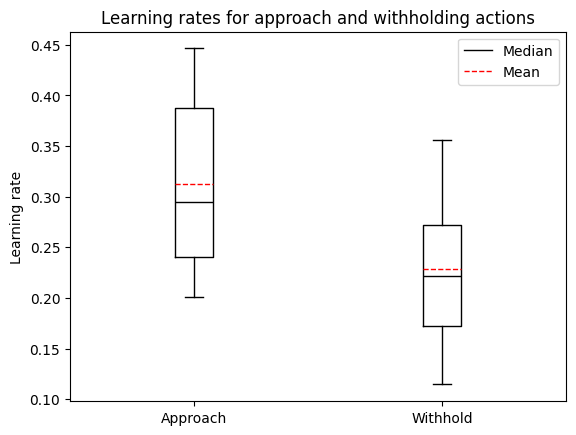

In [150]:
# extract parameters for model 8 from best_params_dict
model_8_params = [{param: param_subject[i] for i, param in enumerate(model8.params.keys())} for param_subject in best_params_dict[8].values()]
lr_app = [param["lr_app"] for param in model_8_params]
lr_wth = [param["lr_wth"] for param in model_8_params]

# make boxplot of learning rates for approach and withholding actions
plt.boxplot([lr_app, lr_wth], meanline=True, showmeans=True, meanprops=dict(color="red", linestyle="--"), medianprops=dict(color="black"))
plt.xticks([1, 2], ["Approach", "Withhold"])
plt.ylabel("Learning rate")
plt.title("Learning rates for approach and withholding actions")
plt.legend(["Median", "Mean"])
plt.show();

The best obtained fit for the data for the best performing model shows higher mean learning rate for approach (i.e. where optimal action is to go) than for withhold cues (i.e. where the optimal action is no go). This suggests, assuming the model is correct, that subjects learn on average faster in the approach compared to the withhold conditions, or in other words, learn faster to go than to not go. 

Possibly, since the pavlovian bias was fitted as non-zero, this might be due to a higher action-valence coupling for go-actions than for no-go actions. Because the learning rate for approach cues is higher, the net effect of the pavlovian bias for the Q-update is higher in cases of approach cues than in cases of withhold cues. But this might be checked by fitting a model equal to model 8 but with two different pavlovian bias parameters for approach and withhold cues, expecting a smaller or no difference in learning rates anymore.

##### Bonus: Fitting first subject 10 times with different initial parameters

In [151]:
initial_params_list = [{} for _ in range(10)]
# Randomly sample 10 values for each parameter within the bounds
for param, bounds in param_bounds.items():
    param_values = np.linspace(bounds[0], bounds[1], 10)
    np.random.shuffle(param_values)
    for i, value in enumerate(param_values):
        initial_params_list[i][param] = value

In [153]:
# Fit model 8 with each set of initial parameters on first subject
model8.set_data(subjects_data[0])
param_bounds_list = [(param_bounds[key]) for key in model8.params.keys()]
best_params_model8 = []
for initial_params in tqdm(initial_params_list):
    best_params = minimize(model8.compute_neg_log_likelihood, [initial_params[key] for key in model8.params.keys()], bounds=param_bounds_list, method=method)
    best_params_model8.append(best_params.x)

100%|██████████| 10/10 [01:05<00:00,  6.50s/it]


In [155]:
model_8_params = [{param: param_subject[i] for i, param in enumerate(model8.params.keys())} for param_subject in best_params_model8]
bias_app = [param["bias_app"] for param in model_8_params]
bias_wth = [param["bias_wth"] for param in model_8_params]

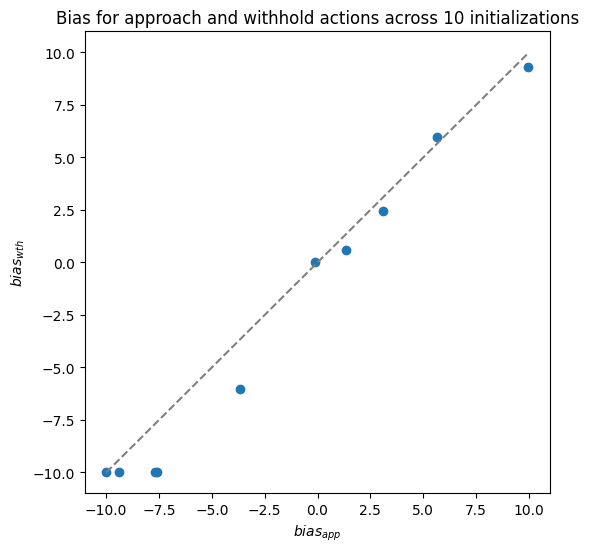

In [166]:
plt.figure(figsize=(6, 6))
plt.scatter(bias_app, bias_wth)
plt.plot([-10, 10], [-10, 10], color="grey", linestyle="--")
plt.xlabel(r"$bias_{app}$")
plt.ylabel(r"$bias_{wth}$")
plt.title("Bias for approach and withhold actions across 10 initializations")
plt.show()

We find multiple local optima reached for different initializations. Most of those minima are rather below the bisectrix, showing that most of the time, a higher bias for approach than for withhold actions fits the data better. Still, this raises the problem that the fit quality depends on parameter initialization, leading to conflicting or missing results because not all possible initializations have been explored. 